In [12]:
import utils.utils as utils
import utils.datasets as datasets
import models.models as models
from utils.train_eval import CrossDatasetValidation

import os
from tqdm import tqdm
from typing import Callable, List, Tuple, Union
from functools import partial

import numpy as np
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from skimage.transform import resize
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
import timm



pd.set_option("display.max_columns", 50)
%load_ext autoreload
%autoreload 2

Smic registered videos have missing frames 

In [33]:
c = datasets.CrossDataset(resize=64, optical_flow=True)

In [13]:
c = datasets.Casme2(resize=64, optical_flow=True)

In [34]:
df = c.data_frame
data = c.data

## Table of AUs from each dataset and total

In [18]:
# Table of aus for paper
action_units = df.loc[:, "AU1":].columns[df.loc[:, "AU1":].sum() > 40].tolist()
au_sum_df = df.groupby("dataset")[action_units].sum()
au_sum_df["Total"] = au_sum_df.sum(1)
au_sum_df.loc["Total"] = au_sum_df.sum(numeric_only=True)
au_sum_df
#au_sum_df.to_latex()

,AU1,AU2,AU4,AU5,AU6,AU7,AU9,AU10,AU12,AU14,AU15,AU17,Total
dataset,,,,,,,,,,,,,
casme,23,17,70,0,1,4,40,3,9,23,14,13,217
casme2,26,22,130,2,13,39,13,16,34,27,16,25,363
fourDmicro,46,54,102,8,25,89,1,2,53,4,6,11,401
mmew,50,41,109,70,10,47,8,38,37,17,6,11,444
samm,6,18,23,10,3,46,5,6,28,13,4,6,168
Total,151,152,434,90,52,225,67,65,161,84,46,66,1593


## Predicting emotions from AUs

Let's try with a few models: logistic regression, SVM, random forests and gradient boosting. 

- Do we care about data leakage or just trying to find a fit?
- Use all AUs and then the selected ones

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator

In [20]:
def predict_emotions_from_aus(
    df: pd.DataFrame,
    dataset_name: str,
    model: BaseEstimator,
    action_units: list = []
):
    action_units = action_units if action_units else df.loc[:, "AU1":].columns
    df_dataset = df[df["dataset"] == dataset_name]
    
    aus = np.array(df_dataset.loc[:, action_units])
    emotions = df_dataset["emotion"]
    model.fit(aus, emotions)
    predicted_emotions = model.predict(aus)
    f1 = f1_score(emotions, predicted_emotions, average="macro")
    print(f1)
    return emotions, predicted_emotions

In [21]:
from utils.utils import dataset_aus

In [22]:
y, y_hat = predict_emotions_from_aus(df, "mmew", GradientBoostingClassifier())

0.9582190502610853


#### Clashes between AUs and emotions

In [23]:
def au_clashes(df: pd.DataFrame, dataset_name: str = None) -> dict:
    """
    Sees if the AUs are the same but the emotion is different in a dataframe
    """
    # Remove any extras from AUs, e.g., R, (k), A
    dft = df.copy()
    dft["CAU"] = dft.loc[:, "AU1":].transpose().apply(lambda x: "+".join([au for au, idx in x.items() if idx]))
    # Create a dict with the au and emotion mappings
    d = {}
    dft = dft[dft["dataset"] == dataset_name] if dataset_name in dft["dataset"].unique() else dft
    for i, row in dft.iterrows():
        if row["CAU"] not in d:
            d.setdefault(row["CAU"], [])
        if row["emotion"] not in d[row["CAU"]]:
            d[row["CAU"]].append(row["emotion"])

    # See if there are clashes
    clashes = {}
    for s in d:
        if len(d[s]) > 1:
            clashes[s] = d[s]
    return clashes

In [24]:
au_clashes(df, "casme")

{'AU4': ['tense', 'disgust'],
 'AU12': ['happiness', 'comtempt'],
 'AU17': ['repression', 'tense'],
 'AU15': ['repression', 'disgust', 'tense'],
 'AU9': ['disgust', 'tense'],
 'AU24': ['repression', 'tense'],
 'AU10': ['disgust', 'happiness'],
 'AU16': ['tense', 'surprise'],
 'AU1': ['sadness', 'surprise']}

In [25]:
au_clashes(df)

{'AU4': ['tense',
  'disgust',
  'others',
  'Anger',
  'Negative',
  'Others',
  'repression'],
 'AU12': ['happiness',
  'comtempt',
  'others',
  'Happiness',
  'Positive',
  'Others'],
 'AU14': ['repression',
  'others',
  'happiness',
  'Contempt',
  'Repression',
  'fear',
  'sadness'],
 'AU17': ['repression',
  'tense',
  'others',
  'Sadness',
  'Anger',
  'Positive+Repression',
  'Repression',
  'sadness'],
 'AU15': ['repression', 'disgust', 'tense', 'happiness'],
 'AU9': ['disgust', 'tense', 'Disgust', 'Negative'],
 'AU18': ['tense', 'others', 'repression', 'surprise'],
 'AU1+AU2': ['surprise',
  'Surprise',
  'Surprise+Negative',
  'Surprise+Positive',
  'sadness'],
 'AU24': ['repression', 'tense', 'others', 'Other', 'Positive+Repression'],
 'AU4+AU14': ['tense', 'others', 'repression', 'fear'],
 'AU7': ['tense', 'others', 'Anger', 'Negative', 'Others', 'anger'],
 'AU10': ['disgust', 'happiness', 'Disgust'],
 'AU14+AU15': ['tense', 'happiness', 'repression'],
 'AU15+AU17': ['

### Label cardinality for AUs

In [26]:
def cardinality(df: pd.DataFrame):
    dft = df.copy()
    dft["cardinality"] = dft[dataset_aus["cross"]].sum(1)
    print(dft.groupby("dataset")["cardinality"].mean())
    
cardinality(df)

dataset
casme         1.148148
casme2        1.417969
fourDmicro    1.501873
mmew          1.480000
samm          1.056604
Name: cardinality, dtype: float64


In [27]:
df.groupby("dataset")["n_frames"].mean()

dataset
casme         22.052910
casme2        66.804688
fourDmicro    21.374532
mmew          39.916667
samm          74.314465
Name: n_frames, dtype: float64

## Testing Validation for individual datasets, cross validation and MEGC

Should also include ones for individual emotions and the ability to choose which datasets go into cross validation?

In [28]:
from torchvision import transforms

In [57]:
class Config:
    action_units = ['AU1', 'AU2', 'AU4', 'AU7', 'AU12', 'AU14', 'AU15', 'AU17']
    device = torch.device("cuda:0")
    #device = torch.device("cpu")
    epochs = 200
    weight = torch.tensor((1 / df.loc[:, action_units].sum(0) * 100).tolist()).to(device)
    criterion = utils.MultiLabelBCELoss(weight=weight)
    evaluation = utils.MultiLabelF1Score(average="macro")
    # Optimizer
    learning_rate = 1e-4
    weight_decay = 1e-3
    optimizer = optim.Adam
    scheduler = None
    # Dataloader
    batch_size = 128
    #train_transform = {"spatial": transforms.TrivialAugmentWide(num_magnitude_bins=2), "temporal": None}
    train_transform = {"spatial": None, "temporal": None}
    test_transform = {"spatial": None, "temporal": None}
    model = models.SSSNet(output_size=len(action_units))

In [29]:
from utils.train_eval import IndividualDatasetAUValidation, CrossDatasetValidation

In [35]:
out = IndividualDatasetAUValidation(Config).validate(df, data)

Subject: 01, n=9 | train_f1: 0.9914 | test_f1: 0.9297
Test F1 per AU: [('AU1', 100.0), ('AU2', 100.0), ('AU4', 100.0), ('AU7', 43.75), ('AU12', 100.0), ('AU14', 100.0), ('AU15', 100.0), ('AU17', 100.0)]

Subject: 02, n=13 | train_f1: 0.9936 | test_f1: 0.7305
Test F1 per AU: [('AU1', 100.0), ('AU2', 45.83), ('AU4', 100.0), ('AU7', 100.0), ('AU12', 45.83), ('AU14', 70.68), ('AU15', 40.91), ('AU17', 81.16)]

Subject: 03, n=7 | train_f1: 0.9935 | test_f1: 0.7487
Test F1 per AU: [('AU1', 100.0), ('AU2', 46.15), ('AU4', 65.0), ('AU7', 41.67), ('AU12', 100.0), ('AU14', 100.0), ('AU15', 100.0), ('AU17', 46.15)]

Subject: 04, n=5 | train_f1: 0.9922 | test_f1: 0.8313
Test F1 per AU: [('AU1', 100.0), ('AU2', 100.0), ('AU4', 44.44), ('AU7', 76.19), ('AU12', 100.0), ('AU14', 44.44), ('AU15', 100.0), ('AU17', 100.0)]

Subject: 05, n=19 | train_f1: 0.9948 | test_f1: 0.7991
Test F1 per AU: [('AU1', 100.0), ('AU2', 73.73), ('AU4', 89.2), ('AU7', 100.0), ('AU12', 47.22), ('AU14', 81.9), ('AU15', 47.22),

In [58]:
out = IndividualDatasetAUValidation(Config).validate_n_times(df, data)

100%|██████████| 5/5 [08:08<00:00, 97.61s/it]

AUS: ['AU1', 'AU2', 'AU4', 'AU7', 'AU12', 'AU14', 'AU15', 'AU17', 'Average']
94.6 & 82.2 & 93.0 & 74.1 & 69.0 & 73.0 & 66.4 & 87.1 & 79.9

Subjects:  ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', 'Average']
92.9 & 75.2 & 82.6 & 88.5 & 78.8 & 80.4 & 66.9 & 91.0 & 76.4 & 89.9 & 90.6 & 81.0 & 95.1 & 96.1 & 76.7 & 90.0 & 86.9 & 95.5 & 83.9 & 85.4 & 83.3 & 90.8 & 71.8 & 83.3 & 85.9 & 82.5 & 84.7


In [31]:
class Config:
    action_units = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17']
    device = torch.device("cuda:0")
    #device = torch.device("cpu")
    epochs = 200
    weight = torch.tensor((1 / df.loc[:, action_units].sum(0) * 100).tolist()).to(device)
    criterion = utils.MultiLabelBCELoss(weight=weight)
    evaluation = utils.MultiLabelF1Score(average="macro")
    # Optimizer
    learning_rate = 1e-4
    weight_decay = 1e-3
    optimizer = optim.Adam
    scheduler = None
    # Dataloader
    batch_size = 128
    #train_transform = {"spatial": transforms.TrivialAugmentWide(num_magnitude_bins=2), "temporal": None}
    train_transform = {"spatial": None, "temporal": None}
    test_transform = {"spatial": None, "temporal": None}
    model = models.SSSNet(output_size=len(action_units))

In [35]:
out = CrossDatasetValidation(Config).validate(df, data)

100%|██████████| 200/200 [00:15<00:00, 13.14it/s]


Dataset: casme, n=189 | train_f1: 0.9868 | test_f1: 0.6568
Test F1 per AU: [('AU1', 83.52), ('AU2', 84.19), ('AU4', 82.05), ('AU5', 49.06), ('AU6', 48.36), ('AU7', 52.93), ('AU9', 51.45), ('AU10', 60.16), ('AU12', 69.91), ('AU14', 65.29), ('AU15', 66.12), ('AU17', 75.06)]



100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


Dataset: casme2, n=256 | train_f1: 0.9827 | test_f1: 0.7087
Test F1 per AU: [('AU1', 90.56), ('AU2', 83.44), ('AU4', 95.7), ('AU5', 49.8), ('AU6', 64.47), ('AU7', 72.78), ('AU9', 55.36), ('AU10', 53.17), ('AU12', 72.36), ('AU14', 60.0), ('AU15', 72.69), ('AU17', 80.1)]



100%|██████████| 200/200 [00:15<00:00, 13.11it/s]


Dataset: samm, n=159 | train_f1: 0.9826 | test_f1: 0.7037
Test F1 per AU: [('AU1', 70.56), ('AU2', 87.49), ('AU4', 83.51), ('AU5', 63.91), ('AU6', 49.36), ('AU7', 85.92), ('AU9', 66.03), ('AU10', 79.35), ('AU12', 65.05), ('AU14', 56.66), ('AU15', 69.52), ('AU17', 67.04)]



100%|██████████| 200/200 [00:15<00:00, 13.32it/s]


Dataset: fourDmicro, n=267 | train_f1: 0.9714 | test_f1: 0.6468
Test F1 per AU: [('AU1', 86.77), ('AU2', 82.93), ('AU4', 89.43), ('AU5', 47.85), ('AU6', 55.14), ('AU7', 66.73), ('AU9', 49.91), ('AU10', 49.72), ('AU12', 62.72), ('AU14', 64.52), ('AU15', 63.81), ('AU17', 56.64)]



100%|██████████| 200/200 [00:13<00:00, 14.87it/s]


Dataset: mmew, n=300 | train_f1: 0.9763 | test_f1: 0.6741
Test F1 per AU: [('AU1', 87.6), ('AU2', 86.16), ('AU4', 92.93), ('AU5', 43.4), ('AU6', 49.15), ('AU7', 65.56), ('AU9', 59.91), ('AU10', 53.66), ('AU12', 71.89), ('AU14', 64.28), ('AU15', 59.24), ('AU17', 75.13)]

All AUs:  [('AU1', 86.46), ('AU2', 84.74), ('AU4', 90.49), ('AU5', 49.29), ('AU6', 55.58), ('AU7', 71.2), ('AU9', 56.91), ('AU10', 57.88), ('AU12', 68.64), ('AU14', 62.39), ('AU15', 66.4), ('AU17', 73.84)]
Mean f1:  68.65


In [7]:
out = CrossDatasetValidation(Config).validate_n_times(df, data)

100%|██████████| 5/5 [06:11<00:00, 74.37s/it]

AUS: ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'Average']
87.6 & 84.6 & 90.2 & 49.7 & 54.0 & 71.9 & 60.5 & 55.9 & 68.2 & 62.7 & 68.9 & 76.6 & 69.2

Datasets:  ['casme', 'casme2', 'samm', 'fourDmicro', 'mmew', 'Average']
66.1 & 71.5 & 70.7 & 66.5 & 66.9 & 68.3


## Adding magnification to data loader

In [25]:
c = datasets.CrossDataset(resize=False, color=True, magnify=True, magnify_params={"alpha": 20, "r1": 0.5, "r2": 0.04})

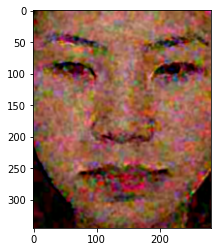

In [26]:
plt.imshow(c.data[3][10])